<a href="https://colab.research.google.com/github/ahmeterdem/FLOWERFLOPEN/blob/main/MyProjectv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/adap/flower/tree/main/examples/vertical-fl

Cloning into 'vertical-fl'...
fatal: repository 'https://github.com/adap/flower/tree/main/examples/vertical-fl/' not found


In [1]:
!git clone https://github.com/ahmeterdem/DATA.git

Cloning into 'DATA'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 13 (delta 0), reused 10 (delta 0), pack-reused 0
Receiving objects: 100% (13/13), 54.28 KiB | 4.17 MiB/s, done.


Kütüphaneler

In [2]:
!pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib scikit-learn numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.7/364.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
ERROR: pip's dependency r

AE: Imports

In [3]:
import torch.nn as nn
import numpy as np
import pandas as pd

Task

In [11]:
import torch.nn as nn
import numpy as np
import pandas as pd


def _bin_age(age_series):
    bins = [-np.inf, 10, 40, np.inf]
    labels = ["Child", "Adult", "Elderly"]
    return (
        pd.cut(age_series, bins=bins, labels=labels, right=True)
        .astype(str)
        .replace("nan", "Unknown")
    )


def _extract_title(name_series):
    titles = name_series.str.extract(" ([A-Za-z]+)\.", expand=False)
    rare_titles = {
        "Lady",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    }
    titles = titles.replace(list(rare_titles), "Rare")
    titles = titles.replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
    return titles


def _create_features(df):
    # Convert 'Age' to numeric, coercing errors to NaN
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
    df["Age"] = _bin_age(df["Age"])
    df["Cabin"] = df["Cabin"].str[0].fillna("Unknown")
    df["Title"] = _extract_title(df["Name"])
    df.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True)
    all_keywords = set(df.columns)
    df = pd.get_dummies(
        df, columns=["Sex", "Pclass", "Embarked", "Title", "Cabin", "Age"]
    )
    return df, all_keywords


def get_partitions_and_label():
    df = pd.read_csv("DATA/_static/data/train.csv")
    processed_df = df.dropna(subset=["Embarked", "Fare"]).copy()
    processed_df, all_keywords = _create_features(processed_df)
    raw_partitions = _partition_data(processed_df, all_keywords)

    partitions = []
    for partition in raw_partitions:
        partitions.append(partition.drop("Survived", axis=1))
    return partitions, processed_df["Survived"].values


def _partition_data(df, all_keywords):
    partitions = []
    keywords_sets = [{"Parch", "Cabin", "Pclass"}, {"Sex", "Title"}]
    keywords_sets.append(all_keywords - keywords_sets[0] - keywords_sets[1])

    for keywords in keywords_sets:
        partitions.append(
            df[
                list(
                    {
                        col
                        for col in df.columns
                        for kw in keywords
                        if kw in col or "Survived" in col
                    }
                )
            ]
        )

    return partitions


class ClientModel(nn.Module):
    def __init__(self, input_size):
        super(ClientModel, self).__init__()
        self.fc = nn.Linear(input_size, 4)

    def forward(self, x):
        return self.fc(x)

# AE Data Processing

In [5]:
 df = pd.read_csv("DATA/_static/data/train.csv")
 df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [7]:
 mydf = pd.read_csv("DATA/_static/data/__KANDEGERLERI_20221306_kucuk.csv", sep = ';')
 mydf

,HCT15,HGB14,LY30,LY25,MCH17,MCHC18,MCV16,MO31,MO26,MPV21,NE29,NE24,PCT22,PDW23,PLT20,RBC13,RDW19,WBC12,Transfuzyon
0,24.2,7.8,7.9,62.6,20.6,32.4,63.6,0.5,3.9,7.6,3.7,29.3,0.379,15.9,500,3.80,36.4,12.6,1
1,20.4,6.7,3.8,42.8,20.1,32.8,61.2,1.1,12.2,8.1,3.3,38.0,0.348,17.0,432,3.33,30.4,8.8,1
2,36.7,12.8,5.2,44.1,25.3,34.9,72.5,1.8,15.3,8.8,4.3,37.0,0.417,17.4,475,5.06,32.8,11.9,0
3,29.3,9.9,5.1,50.2,24.0,33.6,71.5,0.9,8.6,8.8,3.3,32.4,0.350,15.4,397,4.10,30.3,10.1,1
4,27.0,9.0,5.5,51.8,23.9,33.5,71.3,1.0,9.3,8.1,3.3,31.1,0.277,16.7,343,3.79,30.0,10.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,33.3,11.4,3.1,32.0,27.7,34.1,81.3,0.8,8.3,9.4,5.5,56.2,0.214,17.8,229,4.10,15.9,9.8,0
1104,26.7,9.1,2.3,37.1,26.9,34.0,79.0,0.3,5.5,11.4,3.3,53.4,0.368,19.2,323,3.38,16.1,6.3,1
1105,34.1,11.6,2.3,28.9,27.3,34.1,80.2,0.5,6.7,11.5,4.8,61.3,0.321,19.3,281,4.25,15.5,7.8,0
1106,24.6,8.4,2.5,30.5,27.5,34.1,80.9,0.8,10.3,9.7,2.8,34.0,0.137,17.0,141,3.04,13.2,8.1,1


In [6]:
# @title HCT15 vs HGB14

from matplotlib import pyplot as plt
mydf.plot(kind='scatter', x='HCT15', y='Transfuzyon', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

NameError: name 'mydf' is not defined

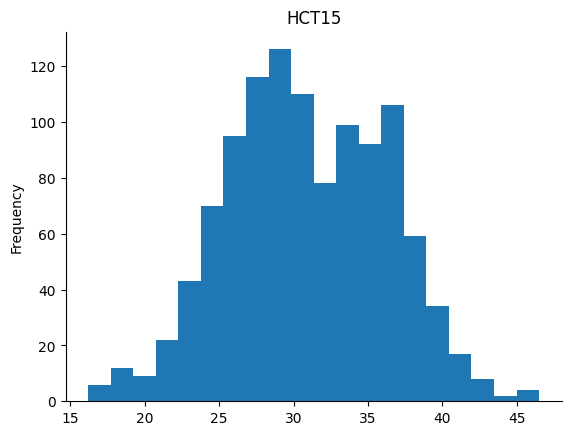

In [7]:
# @title HCT15

from matplotlib import pyplot as plt
mydf['HCT15'].plot(kind='hist', bins=20, title='HCT15')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
    processed_df = df.dropna(subset=["Embarked", "Fare"]).copy()
    processed_df, all_keywords = _create_features(processed_df)
    processed_df

,Survived,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_Unknown,Age_Adult,Age_Child,Age_Elderly,Age_Unknown
0,0,1,0,7.2500,False,True,False,False,True,False,...,False,False,False,False,False,True,True,False,False,False
1,1,1,0,71.2833,True,False,True,False,False,True,...,False,False,False,False,False,False,True,False,False,False
2,1,0,0,7.9250,True,False,False,False,True,False,...,False,False,False,False,False,True,True,False,False,False
3,1,1,0,53.1000,True,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,0,0,0,8.0500,False,True,False,False,True,False,...,False,False,False,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,0,13.0000,False,True,False,True,False,False,...,False,False,False,False,False,True,True,False,False,False
887,1,0,0,30.0000,True,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
888,0,1,2,23.4500,True,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,True
889,1,0,0,30.0000,False,True,True,False,False,True,...,False,False,False,False,False,False,True,False,False,False


In [9]:
my_all_keywords = set(mydf.columns)
my_all_keywords

{'HCT15',
 'HGB14',
 'LY25',
 'LY30',
 'MCH17',
 'MCHC18',
 'MCV16',
 'MO26',
 'MO31',
 'MPV21',
 'NE24',
 'NE29',
 'PCT22',
 'PDW23',
 'PLT20',
 'RBC13',
 'RDW19',
 'Transfuzyon',
 'WBC12'}

In [12]:
partitions, label = get_partitions_and_label()

In [13]:
partitions

[     Pclass_1  Pclass_2  Cabin_F  Cabin_Unknown  Cabin_C  Cabin_T  Cabin_E  \
 0       False     False    False           True    False    False    False   
 1        True     False    False          False     True    False    False   
 2       False     False    False           True    False    False    False   
 3        True     False    False          False     True    False    False   
 4       False     False    False           True    False    False    False   
 ..        ...       ...      ...            ...      ...      ...      ...   
 886     False      True    False           True    False    False    False   
 887      True     False    False          False    False    False    False   
 888     False     False    False           True    False    False    False   
 889      True     False    False          False     True    False    False   
 890     False     False    False           True    False    False    False   
 
      Cabin_A  Cabin_B  Cabin_G  Parch  Pclass_3  

In [14]:
label

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,

In [16]:
myLabel = mydf["Transfuzyon"].values
myLabel

array([1, 1, 0, ..., 0, 1, 0])

In [17]:
def _mypartition_data(df, all_keywords):
    partitions = []
    keywords_sets = [{"HCT15","HGB14","LY30","LY25","MCH17","MCHC18"}, {"MO26","MPV21","NE29","NE24","PCT22","PDW23"}]
    keywords_sets.append(all_keywords - keywords_sets[0] - keywords_sets[1])

    for keywords in keywords_sets:
        partitions.append(
            df[
                list(
                    {
                        col
                        for col in df.columns
                        for kw in keywords
                        if kw in col or "Transfuzyon" in col
                    }
                )
            ]
        )

    return partitions

In [18]:
myPartitions=_mypartition_data(mydf, my_all_keywords)
myPartitions

[      MCH17  HGB14  Transfuzyon  LY25  MCHC18  LY30  HCT15
 0      20.6    7.8            1  62.6    32.4   7.9   24.2
 1      20.1    6.7            1  42.8    32.8   3.8   20.4
 2      25.3   12.8            0  44.1    34.9   5.2   36.7
 3      24.0    9.9            1  50.2    33.6   5.1   29.3
 4      23.9    9.0            1  51.8    33.5   5.5   27.0
 ...     ...    ...          ...   ...     ...   ...    ...
 1103   27.7   11.4            0  32.0    34.1   3.1   33.3
 1104   26.9    9.1            1  37.1    34.0   2.3   26.7
 1105   27.3   11.6            0  28.9    34.1   2.3   34.1
 1106   27.5    8.4            1  30.5    34.1   2.5   24.6
 1107   28.3   11.4            0  27.6    34.3   2.4   33.4
 
 [1108 rows x 7 columns],
       MPV21  PCT22  MO26  NE24  NE29  PDW23  Transfuzyon
 0       7.6  0.379   3.9  29.3   3.7   15.9            1
 1       8.1  0.348  12.2  38.0   3.3   17.0            1
 2       8.8  0.417  15.3  37.0   4.3   17.4            0
 3       8.8  0.350 

In [19]:
class myClientModel(nn.Module):
    def __init__(self, input_size):
        super(ClientModel, self).__init__()
        self.fc = nn.Linear(input_size, 4)

    def forward(self, x):
        return self.fc(x)

Client

In [20]:
import flwr as fl
import torch
from sklearn.preprocessing import StandardScaler

# from task import ClientModel


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, data):
        self.cid = cid
        self.train = torch.tensor(StandardScaler().fit_transform(data)).float()
        self.model = ClientModel(input_size=self.train.shape[1])
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=0.01)
        self.embedding = self.model(self.train)

    def get_parameters(self, config):
        pass

    def fit(self, parameters, config):
        self.embedding = self.model(self.train)
        return [self.embedding.detach().numpy()], 1, {}

    def evaluate(self, parameters, config):
        self.model.zero_grad()
        self.embedding.backward(torch.from_numpy(parameters[int(self.cid)]))
        self.optimizer.step()
        return 0.0, 1, {}

Strategy

In [21]:
import flwr as fl
import torch
import torch.nn as nn
import torch.optim as optim
from flwr.common import ndarrays_to_parameters, parameters_to_ndarrays


class ServerModel(nn.Module):
    def __init__(self, input_size):
        super(ServerModel, self).__init__()
        self.fc = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        return self.sigmoid(x)


class Strategy(fl.server.strategy.FedAvg):
    def __init__(
        self,
        labels,
        *,
        fraction_fit=1,
        fraction_evaluate=1,
        min_fit_clients=2,
        min_evaluate_clients=2,
        min_available_clients=2,
        evaluate_fn=None,
        on_fit_config_fn=None,
        on_evaluate_config_fn=None,
        accept_failures=True,
        initial_parameters=None,
        fit_metrics_aggregation_fn=None,
        evaluate_metrics_aggregation_fn=None,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.model = ServerModel(12)
        self.initial_parameters = ndarrays_to_parameters(
            [val.cpu().numpy() for _, val in self.model.state_dict().items()]
        )
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01)
        self.criterion = nn.BCELoss()
        self.label = torch.tensor(labels).float().unsqueeze(1)

    def aggregate_fit(
        self,
        rnd,
        results,
        failures,
    ):
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Convert results
        embedding_results = [
            torch.from_numpy(parameters_to_ndarrays(fit_res.parameters)[0])
            for _, fit_res in results
        ]
        embeddings_aggregated = torch.cat(embedding_results, dim=1)
        embedding_server = embeddings_aggregated.detach().requires_grad_()
        output = self.model(embedding_server)
        loss = self.criterion(output, self.label)
        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()

        grads = embedding_server.grad.split([4, 4, 4], dim=1)
        np_grads = [grad.numpy() for grad in grads]
        parameters_aggregated = ndarrays_to_parameters(np_grads)

        with torch.no_grad():
            correct = 0
            output = self.model(embedding_server)
            predicted = (output > 0.5).float()

            correct += (predicted == self.label).sum().item()

            accuracy = correct / len(self.label) * 100

        metrics_aggregated = {"accuracy": accuracy}

        return parameters_aggregated, metrics_aggregated

    def aggregate_evaluate(
        self,
        rnd,
        results,
        failures,
    ):
        return None, {}

My Sİmulation

In [22]:
import flwr as fl
import numpy as np
#from strategy import Strategy
#from client import FlowerClient
from pathlib import Path
#from task import get_partitions_and_label




def client_fn(cid):
    return FlowerClient(cid, myPartitions[int(cid)]).to_client()


# Start Flower server
hist = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=100),
    strategy=Strategy(myLabel),
)

results_dir = Path("_static/myresults")
results_dir.mkdir(exist_ok=True)
np.save(str(results_dir / "hist.npy"), hist)

INFO :      Starting Flower simulation, config: num_rounds=100, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-14 16:30:54,115	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 8001026459.0, 'object_store_memory': 4000513228.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Using initial global par

FileNotFoundError: [Errno 2] No such file or directory: '_static/myresults'

Simulation

In [ ]:
import flwr as fl
import numpy as np
#from strategy import Strategy
#from client import FlowerClient
from pathlib import Path
#from task import get_partitions_and_label

partitions, label = get_partitions_and_label()


def client_fn(cid):
    return FlowerClient(cid, partitions[int(cid)]).to_client()


# Start Flower server
hist = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=1000),
    strategy=Strategy(label),
)

results_dir = Path("_static/results")
results_dir.mkdir(exist_ok=True)
np.save(str(results_dir / "hist.npy"), hist)

Streaming output truncated to the last 5000 lines.
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 752]
INFO:flwr:[ROUND 752]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_evaluate: strategy sampled 3 clients (out of 3)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 753]
INFO:flwr:[ROUND 753]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)
INFO :      aggregate_fit: received

Plot

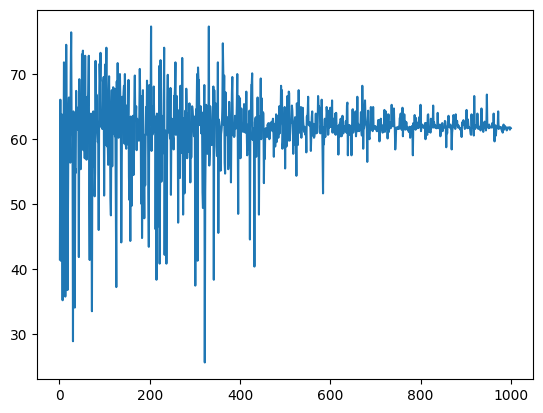

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

if __name__ == "__main__":
    hist = np.load("_static/results/hist.npy", allow_pickle=True).item()
    rounds, values = zip(*hist.metrics_distributed_fit["accuracy"])
    plt.plot(np.asarray(rounds), np.asarray(values))
    plt.savefig("_static/results/accuracy.png")